# Flow matching tutorial
*Séminaire au vert OBELIX 2025*

In [1]:
import torch
from torchdiffeq import odeint_adjoint as odeint

import numpy as np
import ot
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime as dt
from pathlib import Path

import data_utils
import models

from importlib import reload # to be able to modify the modules and reload them without needing to restart the kernel.
def reload_all(): 
    reload(data_utils); reload(models)
reload_all()

from argparse import Namespace

device = "cuda" if torch.cuda.is_available() else "cpu"

## 1/ General framework

References:\
Blog: [Conditional Flow Matching Blog](https://dl.heeere.com/conditional-flow-matching/blog/conditional-flow-matching/) \
Paper:  [Flow matching paper](https://arxiv.org/pdf/2210.02747)

The goal of flow matching, and of **generative modelling** in general, is to **sample a distribution $p^*$** from which we only know samples. One idea is to **find a function that "transforms" a simple source distribution $p_0$** (e.g. $\mathcal{N}(0, I_d)$) into the target distribution $p^*$: then we only need to sample $p_0$ and to send those samples through the learnt function. 

To do so, the idea of flow matching is to transform a source distribution $p_0$ into the target distribution $p_1$ by defining a specific probability path $(p_t)_{t\in[0,1]}$ between $p_0$ and $p_1$. This defines a time-dependent flow $\Psi: [0,1] \times \mathbb{R}^d \rightarrow \mathbb{R}^d$ given as the solution of the ODE driven by a vector field $u$ at time $t$ with initional condition $x(0)=x$:
$$\begin{cases}
  \frac{d}{dt}x(t) = u_t(x(t))\\ 
  x(0) = x\\
\end{cases}
$$ 


The flow $\Psi$ pushes $p_0$ to $p_t$: $$p_t=[\Psi_t]*p_0$$ where 
$
[\Psi_t]_*p_0(x) = p_0(\Psi_t^{-1}(x))\det\left[\frac{\partial\Psi_t^{-1}}{\partial x}(x)\right]
$
. Transforming samples of $p_0$ with $\Psi_1$ will therefore give a sample of $p_1$.

$p_t$ and $u$ are linked by the continuity equation: 
$\frac{d}{dt} p_t\left(\Psi_t(x)\right) + \operatorname{div}\left(v_t\left(\Psi_t(x)\right)\right) = 0$.


<p align="center">
  <img src="image.png" alt="amt text" title="title" />
</p>


### Modeling choices

One could directly learn:
$$
\mathcal{L}_{FM}(\theta) = \mathbb{E}_{t, p_t(x)} \lVert v_t(x) - u_t(x) \rVert^2 
$$

However this objective is not tractable, therefore we consider a latent variable $z$:

Marginal distribution:
$$p_t(x)=\int p_t\left(x \mid z\right) q\left(z\right) d z$$ 
Velocity field:
$$u_t(x)=\int u_t\left(x \mid z\right) \frac{p_t\left(x \mid z\right) q\left(z\right)}{p_t(x)} d z$$

and define the conditional flow matching (CFM) objective based on latent variables:
$$
\mathcal{L}_{CFM}(\theta) = \mathbb{E}_{\substack{t\sim \mathcal{U}(0, 1)\\ z\sim q\\ x\sim p_t(\cdot|z)}} \big\| v^\theta_t(x) - u_t(x|z)\|^2
$$ 
which is actually equal to $\mathcal{L}_{FM}$ up to some constant.

There multiple possible design choices. <!--The original paper consider $z=x_1$ where $x_1$ is a data point from the target distribution. We can also consider couplings $(x_0, x_1)$ where $(x_0, x_1) \sim q(x_0, x_1)$. -->
- independent $z=(x_0, x_1) \sim q=p_0 \otimes p_1$, with $p_t(x|z) = \delta_{(1-t)x_0 + tx_1}$
- conical $z = (x_1) \sim q=p_1$, with $p_t(x|z) = \mathcal{N}(tx_1, (1-t)^2)$ (assuming $p_0 = \mathcal(0, 1)$)
- the optimal transport plan $z = (x_0, x_1) \sim \pi^*$, with $p_t(x|z) = \delta_{(1-t)x_0 + tx_1}$

<!--The goal of flow matching, and of **generative modelling** in general, is to **sample a distribution $p^*$** from which we only know samples. One idea is to **find a function that "transforms" a simple source distribution $p_0$** (e.g. $\mathcal{N}(0, I_d)$) into the target distribution $p^*$: then we only need to sample $p_0$ and to send those samples through the learnt function. 

There are several ways to do so. The approach followed by **flow-based methods** is to say that we may define this function as the **flow (the solution) of some Ordinary Differential Equation** (ODE). To make this more concrete, let us consider a time dependent vector field $v_t$ on $\mathbb{R}^d$. It defines the ODE
$$y'(t) = v_t(y(t)).$$
The flow of this equation is the function $\Psi_t: \mathbb{R}^d \to \mathbb{R}^d$ that gives the solution for any $t$ and and initial condition $x$. So it satisfies $\frac{d}{dt}\Psi_t(x) = v_t(\Psi_t(x))$. Such a flow also acts on distribution through the push-forward operator $[\Psi_t]_{\#}p_0(A) = p_0(\Psi_t^{-1}(A))$. You can see this as the answer to the question "Which distribution do I get when all the points distributed according to $p_0$ are transformed by $\Psi_t$ ?". So the flow define a probability path $p_t = [\Psi_t]_\#p_0$, which is linked with the vector field through the continuity equation
$$\frac{d}{dt}p_t + div(v_tp_t) = 0.$$
**So, to summarise, the idea of flow-based methods is to find a vector field $v_t$ whose associated probability path $(p_t)_t$ starts in $p_0$ and ends up in the target distribution $p_1 = p^*$.**

There are many such probability paths $(p_t)_t$. The idea of **flow matching** is to **define one of them, with a quite simple mathematical expression**, and to learn the corresponding vector field. To define it, they introduce a **latent variable** $z$ (with some distribution $q$) and propose **conditional probability paths** $p_t(x|z)$ with very simple expressions such that
$$\int p_0(x|z) q(z)dz = p_0 \qquad \text{ and } \int p_1(x|z)q(z)dz = p^*.$$
This construction defines a whole probability path through the formula $p_t(x) = \int p_t(x|z) q(z) dt$. Then we only have to find the corresponding vector field $u^*_t$.

Possible choices are:
- independent $z=(x_0, x_1) \sim q=p_0 \otimes p_1$, with $p_t(x|z) = \delta_{(1-t)x_0 + tx_1}$
- conical $z = (x_1) \sim q=p_1$, with $p_t(x|z) = \mathcal{N}(tx_1, (1-t)^2)$ (assuming $p_0 = \mathcal(0, 1)$)
- the optimal transport plan $z = (x_0, x_1) \sim \pi^*$, with $p_t(x|z) = \delta_{(1-t)x_0 + tx_1}$

Flow matching consist in parametrising some vector field $v_t^\theta$ (with some neural network for instance) and minimising the loss
$$L(\theta) = \mathbb{E}_{\substack{t\sim \mathcal{U}(0, 1)\\ x\sim p_t}} \big\| v^\theta_t(x) - u^*_t(x)\|^2.$$
But the vector field $u^*$ is intractable. The tricks comes from the fact that we can rewrite this loss this way 
$$\color{yellow} L(\theta) = \mathbb{E}_{\substack{t\sim \mathcal{U}(0, 1)\\ z\sim q\\ x\sim p_t(\cdot|z)}} \big\| v^\theta_t(x) - u_t(x|z)\|^2$$
with $u_t(\cdot|z)$ the vector field associated to probability path $p_t(\cdot|z)$ (which is very easy to express). This lead to a tractable method, called Conditional Flow Matching.-->

**Question 1:** complete the `train_FM_model` method of the `FLOW_MATCHING` class, using the conditioning strategy of your choice.

**Question 2:** complete the `apply_flow_matching` method to compute the trajectories of points sampled in the latent distribution and ending (hopefully !) in the target distributions. You can consider the `odeint_adjoint` method of `torchdiffeq` package. 

In [ ]:
# Many parts of this code come from repository https://github.com/annegnx/PnP-Flow/
# illustrating paper 
# Martin, S., Gagneux, A., Hagemann, P. & Steidl, G. PnP-Flow: Plug-and-Play Image Restoration with Flow Matching. 2024.


class FlowMatching(object):

    def __init__(self, model, device, args):
        """
        Args:
            model (nn.Module): model that computes the vector field for a given x (N, *data_shape) and a given t (N,).
            device (str): device on which to perform the training.
            args (Namespace): contains the different parameters.
        """
        self.data_shape = args.data_shape
        self.ndim = len(self.data_shape)

        self.device = device
        self.args = args
        self.lr = args.lr
        self.model = model.to(device)

    def train_FM_model(self, train_loader, opt, num_epoch):
        """Learn the flow-matching model on a given dataloader, with a given optimiser. More precisely, update the weights of self.model.

        Args:
            train_loader (DataLoader): DataLoader of the data to train on. Yields tuples (data_point, label) even if the label is not used.
            opt (optimiser): optimiser.
            num_epoch (int): number of epochs.
        """
        
        self.loss_history = [] # You can store the loss of each epoch in this list.
        tq = tqdm(range(num_epoch))

        for ep in tq:

            epoch_loss = 0
            for iteration, (x, labels)in enumerate(train_loader):
                
                # FILL IN HERE
                # - sample the latent distribution
                # - change the sample according to the conditioning strategy you have chosen
                # - sample times uniformly in [0, 1]
                # - compute the interpolation between the latent_samples and data point at given times
                # - determine the desired vector outputted by the model at the given (point, time)
                # - compute the loss as an aggregation of the square euclidean distance between the desired and the outputted vectors.
                # - do an optimisation step

                epoch_loss += loss.item() * len(x)

            epoch_loss /= len(train_loader.dataset)
            tq.set_postfix({"loss": epoch_loss})
            self.loss_history.append(epoch_loss)

    def apply_flow_matching(self, NO_samples, time_points):
        self.model.eval()
        with torch.no_grad():
            model_class = models.cnf(self.model) # convert the signature so that it is adapted to odeint
            # FILL IN HERE
            # - sample from latent
            # - compute the trajectories

        return # fill
    
    def save_model(self, folder="weights", name=None):
        if name is None:
            name = f"model_{dt.datetime.now().isoformat()}.pt"
        
        path = Path(folder) / name
        dico = {
            "model": self.model.state_dict(),
            "args": vars(self.args),
            "device": self.device,
            "latent_sampler": self.latent_sampler
        }
        torch.save(dico, path)
    
    def load_model(self, path):
        dico = torch.load(path)
        self.model.load_state_dict(dico["model"])


    def train(self, target_loader):

        # define optimiser
        opt = torch.optim.Adam(self.model.parameters(), lr=self.args.lr)

        # start training
        self.train_FM_model(target_loader, opt, num_epoch=self.args.num_epoch)

## 1D distributions

**Question 3:** The first distribution we will try to sample is a 1D mixture of gaussians. The mixture is defined in data_utils, and you just have to call `data_utils.DataLoaders("gaussians", batch_size_train, batch_size_test)` to get your dataloader. Define a small model with the `models.ODEFunc` class (MLP with time dependancy), that will serve as vector field. Then train the flow matching on the mixture. 

In [ ]:
args = Namespace(dataset=, num_epoch=, lr=, batch_size=, data_shape=, coupling=) # fill
target_loader = data_utils.create_dataloader(args.dataset, args.batch_size)
model = # fill
model

In [ ]:
# create and train flow matching model
fm = # fill
# train

**Question 4:** Compute the trajectories of samples from the latent distribution and display them.

In [ ]:
times = # fill
trajs = # fill

In [ ]:
plt.plot(times, trajs, c="tab:blue", lw=0.1)
plt.ylabel("x")
plt.xlabel("time t")
plt.show()

Display the probability path, using kernel density estimation

In [12]:
x_discr = torch.linspace(-4, 4, 100)
probability_path = torch.zeros((len(times), len(x_discr)))
for i in range(len(times)):
    kernel = gaussian_kde(trajs[i])
    probability_path[i] = torch.from_numpy(kernel(x_discr))

In [ ]:
plt.pcolormesh(*np.meshgrid(times, x_discr.numpy()), probability_path.T)
plt.xlabel("time t")
plt.ylabel("x")
plt.show()

In [ ]:
for i in range(0, len(times), 10):
    plt.plot(x_discr, probability_path[i].T, c=plt.colormaps["viridis"](times[i]), label=f"t={times[i]:g}")
plt.legend()
plt.xlabel("x")
plt.ylabel("density")
plt.show()

## 2D distributions

The second target distribution we will consider will be an Obélix distribution. To define such a distribution, we use the function `data_utils.load_image` (that loads the .jpg into an array) and the function `data_utils.cloud_transform` that compute a point cloud from it.

In Flow-Matching, we often sample from a gaussian latent distribution. But in practice, we can use any latent distribution ! We will consider the options here:
- in the first one, we will sample from a 2D standard gaussian distribution,
- in the second one, we will sample from an Astérix distribution.

### 0/ Display source and target distributions

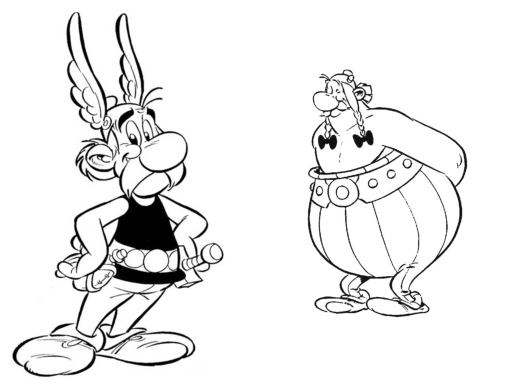

In [4]:
obelix = data_utils.load_image('obelix.jpg')
asterix = data_utils.load_image('asterix.jpg')
plt.subplot(121)
plt.imshow(asterix,cmap='Greys')
plt.axis('off')
plt.subplot(122)
plt.imshow(obelix,cmap='Greys')
plt.axis('off')
plt.show()

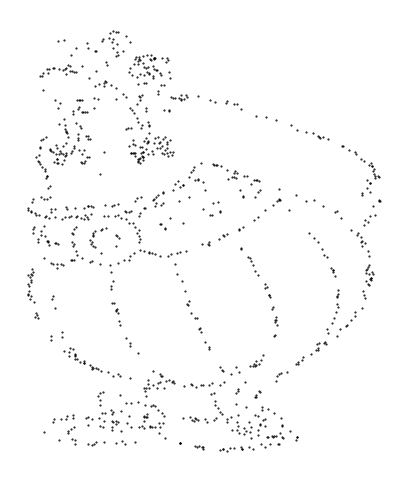

In [5]:
# Example of target distribution
cloud_obelix = data_utils.cloud_transform(obelix, n_samples=1000)
plt.figure(figsize=(5,6))
plt.scatter(cloud_obelix[:,0], cloud_obelix[:,1],marker='.',c='k',s=1)
plt.axis('off')
plt.show()

### 1/ Illustration with the true vector field (no learning)

Independent coupling: $(x_0, x_1) \sim p_0 \times p_1$

$p_t(x|z=(x_0,x_1))=\mathcal{N}(x_0(1-t)+tx_1, \sigma^2)$

$u_t(x|z=(x_0,x_1))=x_1-x_0$

In [118]:
import random 

def cond_ut(x0, x1, t, sigma_min=0.01):
    return (x1-x0)

def flow(x, source, target, t, n_samples=500, sigma_min=0.01):
    s = np.random.randn(n_samples, 2) 
    d = target[random.sample([i for i in range(len(target))], n_samples)]
    xt = (s*(1-t)+t*d)
    diff = x[:, None, :] - xt[None, :, :]  
    sq_dist = np.sum(diff**2, axis=2)

    weights = np.exp(-sq_dist/ (2*sigma_min**2))
    weights /= np.sum(weights, axis=1, keepdims=True)

    ut_cond = cond_ut(s, d, t)
    flow = weights @ ut_cond 

    return flow 


def euler_sample(source, target, timesteps, sigma_min, n_samples):
    x = source
    res = [source]
    for i in range(len(timesteps)-1):
        flows = flow(x, source, target, timesteps[i], n_samples, sigma_min) 
        x = x + flows * (timesteps[i+1]-timesteps[i])
        res.append(x)
    return np.array(res)

In [119]:
#source=np.random.randn(1000, 2) 
n_samples = 100
source = np.random.randn(100,2)
target = data_utils.cloud_transform(obelix, n_samples=500)*10+15
timesteps = np.linspace(0, 1, 100)
res = euler_sample(source, target, timesteps, sigma_min=0.1, n_samples=n_samples)

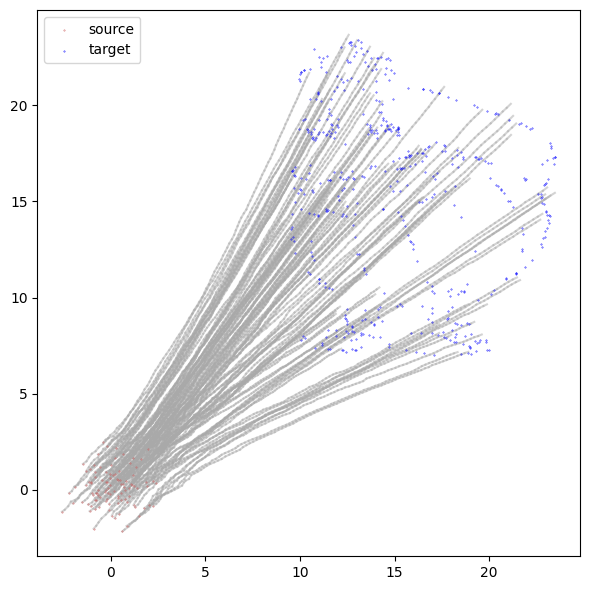

In [120]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()

for i in range(len(timesteps)-1):
    ax.plot([res[i,:,0],res[i+1,:,0]],[res[i,:,1],res[i+1,:,1]],c='darkgrey',alpha=0.5)

ax.scatter(*source.T,c='indianred',s=0.1,label='source',zorder=2)
ax.scatter(*target.T,c='b',s=0.1, label='target',zorder=3)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

Conical flow $p_t(x|z=x_1)=\mathcal{N}(tx_1, (1+t(1-\sigma))^2)$

$u_t(x|z=(x_0,x_1))=\frac{x_1-(1-\sigma_{\text{min}}x)}{1-(1-\sigma_{\text{min}})t}$

In [15]:
def cond_ut(x, x1, t, sigma_min):
    return (x1-x*(1-sigma_min))/(1-t*(1-sigma_min))

def flow(x, source, target, t, sigma_min):
    s = np.random.randn(100,2) #source[random.sample([i for i in range(len(source))], n_samples)]
    d = target #np.random.randn(100,2)*0.7+4 #target[random.sample([i for i in range(len(target))], n_samples)]*
    flows = []
    for i in range(x.shape[0]):
        weight = np.exp(-((x[i]-t*d)**2).sum(axis=1)/(2*(1-(1-sigma_min)*t)**2))
        weight = weight / np.sum(weight, axis=0, keepdims=True)
        ut_cond = cond_ut(x[i], d, t, sigma_min)
        flows.append(np.sum(ut_cond*weight[:, None], axis=0))
    return np.array(flows)

def euler_sample(source, target, timesteps, sigma_min):
    x = source
    res = [source]
    for i in range(len(timesteps)-1):
        flows = flow(x, source, target, timesteps[i], sigma_min) 
        x = x + flows * (timesteps[i+1]-timesteps[i])
        res.append(x)
    return np.array(res)

In [ ]:
source = np.random.randn(100,2)
target = data_utils.cloud_transform(obelix, n_samples=1000)*10+15
timesteps = np.linspace(0, 1, 100)
res = euler_sample(source, target, timesteps, sigma_min=0.001)

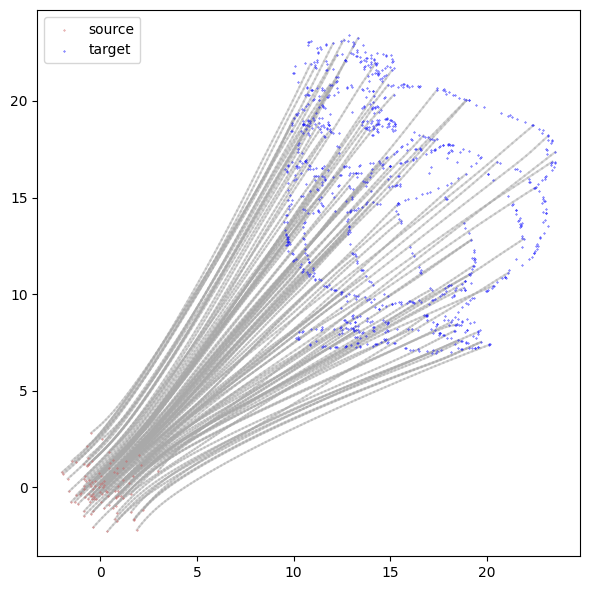

In [17]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()

for i in range(len(timesteps)-1):
    ax.plot([res[i,:,0],res[i+1,:,0]],[res[i,:,1],res[i+1,:,1]],c='darkgrey',alpha=0.5)

ax.scatter(*source.T,c='indianred',s=0.1,label='source',zorder=2)
ax.scatter(*target.T,c='b',s=0.1, label='target',zorder=3)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

### 2/ Flow matching from gaussian

**Question 5:** train a flow matching model to sample an Obélix distribution. An Obélix data loader can be obtained by calling `data_utils.DataLoaders("obelix", ...)`. You may want to display samples obtained with your model, and trajectories latent -> obelix, using the `apply_flow_matching method`.

Don't have too high expectations on the final sampling you can get !

### 3/ Flow matching from data distribution

**Question 6:** Do the same but with an Astérix latent distribution ! As this implies important changes in the code of the flow matching class, you may want to fill and use this new class.

In [ ]:

class FlowMatchingNonGaussian(object):

    def __init__(self, model, device, args):
        """
        Args:
            model (nn.Module): model that computes the vector field for a given x (N, *data_shape) and a given t (N,).
            device (str): device on which to perform the training.
            args (Namespace): contains the different parameters.
        """
        self.data_shape = args.data_shape
        self.ndim = len(self.data_shape)

        self.device = device
        self.args = args
        self.lr = args.lr
        self.model = model.to(device)

    def train_FM_model(self, source_loader, target_loader, opt, num_epoch):
        """Learn the flow-matching model on a given dataloader, with a given optimiser. More precisely, update the weights of self.model.

        Args:
            source_loader (DataLoader): DataLoader for the source distribution. Yields tuples (data_point, label) even if the label is not
                used. Must have the same size and the same batch size as the target_loader.
            target_loader (DataLoader): DataLoader of the data to train on. Yields tuples (data_point, label) even if the label is not used.
            opt (optimiser): optimiser.
            num_epoch (int): number of epochs.
        """
        
        self.loss_history = [] # You can store the loss of each epoch in this list.
        tq = tqdm(range(num_epoch))

        for ep in tq:

            epoch_loss = 0

            for iteration, ((z, _), (x, _)) in enumerate(zip(source_loader, target_loader)):

                # FILL

                epoch_loss += loss.item() * len(x)
            
            epoch_loss /= len(target_loader.dataset)
            tq.set_postfix({"loss": epoch_loss})
            self.loss_history.append(epoch_loss)
            

    def apply_flow_matching(self, source_loader, time_points):
        self.model.eval()
        with torch.no_grad():
            model_class = models.cnf(self.model).to("cpu") # convert the signature so that it is adapted to odeint
            latent, _ = next(iter(source_loader))

            # FILL
            
        return # FILL
    
    def save_model(self, folder="weights", name=None):
        if name is None:
            name = f"model_{dt.datetime.now().isoformat()}.pt"
        
        path = Path(folder) / name
        dico = {
            "model": self.model.state_dict(),
            "args": vars(self.args),
            "device": self.device,
        }
        torch.save(dico, path)
    
    def load_model(self, path):
        dico = torch.load(path)
        self.model.load_state_dict(dico["model"])

    def train(self, source_loader, target_loader):
        """Define the optimiser and train the flow matching model.

        Args:
            source_loader (DataLoader): data loader for the source distribution. Must have the same size and the same batch size as target_loader.
            target_loader (DataLoader): data loader for the target distribution.
        """

        # define optimiser
        opt = torch.optim.Adam(self.model.parameters(), lr=self.args.lr)

        # start training
        self.train_FM_model(source_loader, target_loader, opt, num_epoch=self.args.num_epoch)

Define and train your model

## Images

An illustration of what it gives for high dimensional data like images. Nothing to do, just execute. It can take time (~ 15min). We use very few epochs, so results can be improved if you have more time.

In [ ]:
reload_all()
args_mnist = Namespace(dataset="mnist", num_epoch=100, coupling="product",
    lr=1e-3, batch_size=64, data_shape=(1, 28, 28))
mnist_loader = data_utils.create_dataloader(args_mnist.dataset, batch_size=args_mnist.batch_size)

model_unet = models.UNet(
    input_channels=1,
    input_height=28,
    ch=32,
    ch_mult=(1, 2, 4),
    num_res_blocks=2,
    attn_resolutions=(7,),
    resamp_with_conv=True,
)

In [ ]:
fm_mnist = FlowMatching(model_unet, device=device, args=args_mnist)

In [ ]:
fm_mnist.train(mnist_loader)

In [ ]:
traj_mnist = fm_mnist.apply_flow_matching(10, np.linspace(0, 1, 10))

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
for i in range(len(axes)):
    for j in range(traj_mnist.shape[0]):
        axes[i, j].imshow(traj_mnist[j, i, 0].cpu(), cmap="Greys_r")
        axes[i, j].set_axis_off()
plt.show()